# PID Graph for publications from organization DataCite

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all publications whose metadata includes a DataCite ROR affiliation identifier.

This notebook uses R, but you could do the same thing in another language of your choice. 

It might be also be helpful to consult the [DataCite metadata schema](https://schema.datacite.org) for descriptions of resource types and other available fields. 

# Step 1: Prepare the R GraphQL client
Load necessary libraries and set up the DataCite GraphQL API endpoint. 

In [140]:
# Prepare the R graphql client.

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

# Step 2: Generate the GraphQL query
In this query, we are looking through DataCite DOIs and finding those that include DataCite's own organizational ROR ID as an affiliation identifier. 

DataCite DOIs can be assigned to datasets, publications, software and more. In this example we'll just be looking through DataCite DOIs that are assigned to datasets and publications, but the DataCite GraphQL API lets you specify what you want to search through and how we want to get information back. 

In [141]:
query <- '{
  organization(id: "https://ror.org/04wxnsj81") {
    publications(first: 150) {
      totalCount
      nodes {
        id
        creators {
          id
          affiliation {
            id
          }
        }
        relatedIdentifiers {
          relatedIdentifier
        }
        fundingReferences {
          funderIdentifier
        }
      }
    }
    datasets {
      totalCount
      nodes {
        id
        creators {
          id
          affiliation {
            id
          }
        }
        relatedIdentifiers {
          relatedIdentifier
        }
        fundingReferences {
          funderIdentifier
        }
      }
    }
  }
}'

# Step 3: Run the query

In [142]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [143]:
# Get the number of publications and datasets

display_json(data$data$organization$publications$totalCount)
display_json(data$data$organization$datasets$totalCount)

# Step 4: Make the graph
First we need to prepare the data frame and define all of the nodes for the graph. 

In [ ]:
# generate data frame for nodes
publications <- data.frame(id=data$data$organization$publications$nodes$id, pid_type=c('publication'))
# datasets <- data.frame(id=data$data$organization$datasets$nodes$id, pid_type=c('dataset'))
researchers <- data.frame(id=bind_rows(data$data$organization$publications$nodes$creators)[,1], pid_type=c('researcher'))
researchers <- researchers %>% filter(!is.na(as.character(id)))
# dataset_researchers <- data.frame(id=bind_rows(data$data$organization$datasets$nodes$creators)[,1], pid_type=c('researcher'))
# dataset_researchers <- dataset_researchers %>% filter(!is.na(as.character(id)))
organizations <- data.frame(id=bind_rows(bind_rows(data$data$organization$publications$nodes$creators)[,2])[,1], pid_type=c('organization'))
organizations <- organizations %>% filter(!is.na(as.character(id)))
#references <- data.frame(id=bind_rows(data$data$organization$publications$nodes$relatedIdentifiers)[,1], pid_type=c('publication'))
#references <- references %>% filter(!is.na(as.character(id))) %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
# dataset_references <- data.frame(id=bind_rows(data$data$organization$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('publication'))
#dataset_references <- dataset_references %>% filter(!is.na(as.character(id))) %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
#funders <- data.frame(id=bind_rows(data$data$organization$publications$nodes$fundingReferences)[,1], pid_type=c('funder'))
#dataset_funders <- data.frame(id=bind_rows(data$data$organization$datasets$nodes$fundingReferences)[,1], pid_type=c('funder'))
nodes <- rbind(publications, researchers, organizations)

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

Then we define the edges, looping through each node as we go.

In [ ]:
# loop through nodes, as they can have more than one edge
edges <- data.frame(to=character(), from=character())
nodes_with_creators <- bind_rows(data$data$organization$publications$nodes) %>% filter(lengths(creators) != 0)
for (i in 1:nrow(nodes_with_creators)) {
  row <- data.frame(to=unlist(nodes_with_creators[i,2]), from=nodes_with_creators[i,1])
  edges <- unique(rbind(edges, row))
}
#dataset_nodes_with_creators <- bind_rows(data$data$organization$datasets$nodes) %>% filter(lengths(creators) != 0)
#for (i in 1:nrow(dataset_nodes_with_creators)) {
#  row <- data.frame(to=unlist(dataset_nodes_with_creators[i,2]), from=dataset_nodes_with_creators[i,1])
#  edges <- unique(rbind(edges, row))
#}

#nodes_with_references <- bind_rows(data$data$organization$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
#for (i in 1:nrow(nodes_with_references)) {
#  row <- data.frame(to=unlist(nodes_with_references[i,3]), from=nodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}
#dataset_nodes_with_references <- bind_rows(data$data$organization$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
#for (i in 1:nrow(dataset_nodes_with_references)) {
#  row <- data.frame(to=unlist(dataset_nodes_with_references[i,3]), from=dataset_nodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

#nodes_with_dataset_references <- bind_rows(data$data$organization$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
#for (i in 1:nrow(nodes_with_dataset_references)) {
#  row <- data.frame(to=unlist(nodes_with_dataset_references[i,3]), from=nodes_with_dataset_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

#nodes_with_funding <- bind_rows(data$data$organization$publications$nodes) %>% filter(lengths(fundingReferences) != 0)
#for (i in 1:nrow(nodes_with_funding)) {
#  row <- data.frame(to=unlist(nodes_with_funding[i,4]), from=nodes_with_funding[i,1])
#  edges <- unique(rbind(edges, row))
#}
#dataset_nodes_with_funding <- bind_rows(data$data$organization$datasets$nodes) %>% filter(lengths(fundingReferences) != 0)
#for (i in 1:nrow(dataset_nodes_with_funding)) {
#  row <- data.frame(to=unlist(dataset_nodes_with_funding[i,4]), from=dataset_nodes_with_funding[i,1])
#  edges <- unique(rbind(edges, row))
#}

# express DOIs as URLs
edges <- edges %>% filter(!is.na(as.character(to))) %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

Next we format the graph for display, specifying color, node size, and other choices.

In [ ]:
g <- graph_from_data_frame(d=edges, vertices=nodes)

# add node colors
cols <- brewer.pal(12, "Set3")
display.brewer.pal(12, "Set3")
col = c('#ccff66','#48b1f4','#53c48c')
V(g)[(V(g)$pid_type=="publication")]$color<-'#48b1f4'
V(g)[(V(g)$pid_type=="researcher")]$color<-'#53c48c'
#V(g)[(V(g)$pid_type=="funder")]$color<-'#fecf59'
#V(g)[(V(g)$pid_type=="dataset")]$color<-'#e45718'
V(g)[(V(g)$pid_type=="organization")]$color<-'#ccff66'

# add labels to selected nodes
V(g)$label=NA
#V(g)[(V(g)$id=="https://doi.org/10.5281/zenodo.1202173")]$label<-"B"
#V(g)[(V(g)$pid_type=="funder")]$label <- "A"
#V(g)[(V(g)$pid_type=="funder")]$label.dist <- 1

V(g)$size <- 6
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)

Then we plot the graph and add a legend.

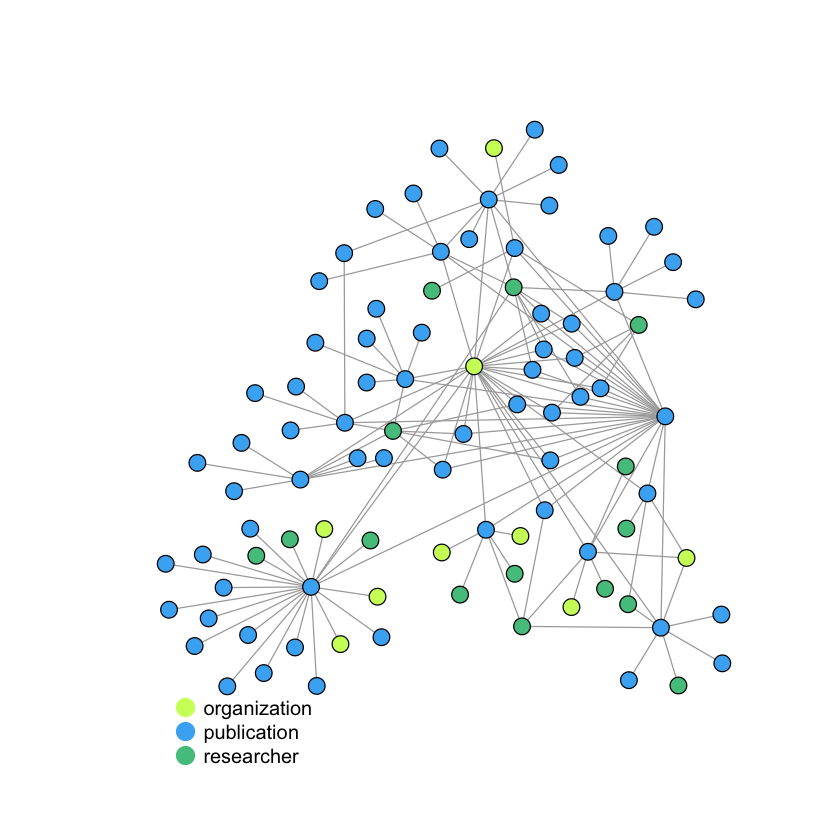

In [144]:
plot(g, layout=l, arrow.mode=0)

# Add a legend
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = col, bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.1, -0.1))

# Step 5: Generate resource lists
To accompany our graph, we can display lists of all the items that are in it. In this example, we're showing APA-formatted citations for everything that's a "publication" resource type. 

In [145]:
# Generate a list of formatted citations in APA format for the publications

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

## Publications

Fenner, M. (2015, August 17). From Pilot to Service. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2016, November 3). A common API for retrieving DataCite Metadata. https://doi.org/10.5438/6WCF-EFW5

Rueda, L. (2016, December 19). 2016 in review. https://doi.org/10.5438/ZWSF-4Y7Y

Fenner, M. (2015, September 16). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Cruse, P. (2015, November 2). DataCite Is an Exciting Place to Be. https://doi.org/10.5438/GA8V-FA94

Rueda, L. (2016, October 24). The Tsinghua University Library joins DataCite. https://doi.org/10.5438/ESYS-F867

Rueda, L. (2015, December 5). DataCite Profiles and ORCID Auto-Update webinar. https://doi.org/10.5438/CJT2-T6DZ

Fenner, M. (2016, May 13). Data catalog cards: simplifying article/data linking. https://doi.org/10.5438/CAB5-TEG0

Fenner, M. (2016, November 1). Announcing the Organization Identifier Project: a Way Forward. https://doi.org/10.5438/TNHX-54CG

Fenner, M. (2015, October 29). Explaining the DataCite/ORCID Auto-update. https://doi.org/10.5438/3DFW-Z4KQ

Fenner, M. (2016, July 5). Relaunching DataCite Search. https://doi.org/10.5438/VQ2T-VR4K

Rueda, L. (2016, June 27). Our New Website: Dynamic, Responsive and Adapted to your Needs. https://doi.org/10.5438/QW2X-PGCY

Rueda, L. (2016, March 11). Open Science, Open Data and DataCite DOIs. https://doi.org/10.5438/SS2R-9CNS

Fenner, M. (2017, January 9). Using Schema.org for DOI Registration. https://doi.org/10.5438/0000-00CC

Rueda, L. (2017, March 2). Welcoming Children’s Hospital of Philadelphia to the community! https://doi.org/10.5438/0000-9G41

Cruse, P., Witt, M., &amp; Starr, J. (2017, August 4). EZID DOI Service is Evolving. https://doi.org/10.5438/0X88-GVGE

Haak, L., Cruse, P., &amp; Pentz, E. (2018, February 1). Next steps for the Organization ID Initiative: Report from the Stakeholder Meeting. https://doi.org/10.5438/SPFW-5Q39

Rueda, L. (2016, February 18). DataCite to Dublin Core application profile (DC2AP). https://doi.org/10.5438/BZAK-W7E4

Fenner, M., Katz, D. S., Nielsen, L. H., &amp; Smith, A. (2018, May 17). DOI Registrations for Software. https://doi.org/10.5438/1NMY-9902

Lowenberg, D., Budden, A., &amp; Cruse, P. (2018, June 5). It’s Time to Make Your Data Count! https://doi.org/10.5438/PRE3-2F25

Dasler, R. (2018, September 19). Data sharing made easier: use Repository Finder to find the right repository for your data. https://doi.org/10.5438/WDAY-8958

Cousijn, H., &amp; Lowenberg, D. (2018, October 22). Make Data Count and Scholix join FORCE(2018)s. https://doi.org/10.5438/QM7P-WY23

Dasler, R. (2018, October 26). Making testing simpler: our new approach to test accounts. https://doi.org/10.5438/6F6R-JF56

Dasler, R., &amp; de Smaele, M. (2019, March 20). Announcing schema 4.2. https://doi.org/10.5438/WVKV-FZ40

Dasler, R. (2019, April 17). Usage Stats for datasets: now available in DataCite Search. https://doi.org/10.5438/EEPD-3X92